# Подготовка новых признаков из сырых данных к 6 неделе
Глазунов А.В.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [2]:
cd /content/gdrive/'My Drive'/Colab_Notebooks/ML_c6_TAXI


/content/gdrive/My Drive/Colab_Notebooks/ML_c6_TAXI


In [0]:
PATH_TO_DATA = 'data'

In [0]:
import warnings
warnings.filterwarnings('ignore')

import os
import pandas as pd
import numpy as np
from scipy import stats
from tqdm import tqdm_notebook
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
import gc
import statsmodels.api as sm

from itertools import product

In [14]:
regions = pd.read_csv(os.path.join(PATH_TO_DATA,'regions.csv'),sep=';')
regions.head()

,region,west,east,south,north
0,1,-74.25559,-74.244478,40.496120,40.504508
1,2,-74.25559,-74.244478,40.504508,40.512896
2,3,-74.25559,-74.244478,40.512896,40.521285
3,4,-74.25559,-74.244478,40.521285,40.529673
4,5,-74.25559,-74.244478,40.529673,40.538061


In [0]:
def taxi_features_aggregation(taxi_data,reg_data,new_feature_name):

  """  
  Описание

  Данная функция принимает на вход загруженные 
  таблицу с поездками и список зон с координатами

  Возвращает дополнительные данные для расчета признака,
  (time_length х regions_length)

  """
  df = taxi_data.copy()
  
  regions = reg_data.copy()

  #границы города, y - широта, x - долгота
  (Ymin,Ymax) = (regions.south.min(),regions.north.max())
  (Xmin,Xmax) = (regions.west.min(), regions.east.max())

  #очистка 
  df.drop(df[df.pickup_latitude <= Ymin].index,inplace =True )
  df.drop(df[df.pickup_latitude >= Ymax].index,inplace =True )
  df.drop(df[df.pickup_longitude <= Xmin].index,inplace =True )
  df.drop(df[df.pickup_longitude >= Xmax].index,inplace =True )

  df.drop(df[df.passenger_count == 0].index,inplace =True)
  df.drop(df[df.trip_distance == 0].index,inplace =True)
  df.drop(df[df.tpep_pickup_datetime == df.tpep_dropoff_datetime].index,inplace =True)


  cluster_fe = False
  #столбец времени начала (или конца) поездки по часам для построения ряда по часам
  #а также дополнительная чистка при необходимости
  if new_feature_name == 'dropoff_count':
    df['time'] = pd.to_datetime(df.tpep_dropoff_datetime.apply(lambda x: x[:-6])) 
    df['time_pickup'] = pd.to_datetime(df.tpep_pickup_datetime.apply(lambda x: x[:-6]))
    df['pu_month'] = df['time_pickup'].apply(lambda x: x.month)
    df['do_month'] = df['time'].apply(lambda x: x.month)
    df.drop(df[df.dropoff_latitude <= Ymin].index,inplace =True )
    df.drop(df[df.dropoff_latitude >= Ymax].index,inplace =True )
    df.drop(df[df.dropoff_longitude <= Xmin].index,inplace =True )
    df.drop(df[df.dropoff_longitude >= Xmax].index,inplace =True )
    df.drop(df[df.pu_month != df.do_month].index,inplace =True)
    df.drop(df[df.time < df.time_pickup].index,inplace=True)  
  else:
    df['time'] = pd.to_datetime(df.tpep_pickup_datetime.apply(lambda x: x[:-6])) 

  if new_feature_name in ['trip_distance','trip_duration','total_amount']:
    df['time_dropoff'] = pd.to_datetime(df.tpep_dropoff_datetime.apply(lambda x: x[:-6])) 
    df['time_pickup'] = pd.to_datetime(df.tpep_pickup_datetime.apply(lambda x: x[:-6]))
    df['pu_month'] = df['time_pickup'].apply(lambda x: x.month)
    df['do_month'] = df['time_dropoff'].apply(lambda x: x.month)
    df.drop(df[df.pu_month != df.do_month].index,inplace =True)
    df.drop(df[df.time_dropoff < df.time_pickup].index,inplace=True)        
    df.drop(df[df.trip_distance < 0].index,inplace=True) 
    df.drop(df[df.trip_distance > 40].index,inplace=True)     

  #Столбцы для агрегации дополнительных признаков
  
  if new_feature_name == 'payment_type_1':
    df['payment_type_1'] = (df.payment_type == 1).astype(int)
  elif new_feature_name == 'payment_type_2':
    df['payment_type_2'] = (df.payment_type == 2).astype(int)
  elif new_feature_name == 'payment_type_rest':
    df['payment_type_rest'] = (df.payment_type > 2).astype(int)
  elif new_feature_name == 'VendorID==1':
    df['VendorID==1'] = (df.VendorID == 1).astype(int)
  elif new_feature_name == 'trip_duration':
    df['trip_duration'] = (pd.to_datetime(df.tpep_dropoff_datetime) - \
                         pd.to_datetime(df.tpep_pickup_datetime)).values.astype(float)/60e9
  
  #Столбцы для агрегации признаков принадлежности конца поездки кластеру
  
  elif new_feature_name == 'main_cluster_destination':
    cluster_fe = True
    cluster = [1181,1231,1281,1282,1232,1230,1182,1233,1180]
  
  elif new_feature_name =='broadway_cluster_destination':
    cluster_fe = True
    cluster = [1126,1127,1076]  
  
  elif new_feature_name =='airport_cluster_destination':
    cluster_fe = True
    cluster = [1684,1734,1733,1783,2069,2119,2068,2118,2168]
    
  elif new_feature_name =='far_cluster_destination':
    cluster_fe = True
    cluster = [1441,1442,1390,1439,1533,1483,1482,1532,1380,1480,1530,1580,\
                 1630,1426,1376,1377,1378,1272,1221,1273,1274,1175,1225,1222,1172] 
  
  #проверка принадлежности к кластеру для каждого конца поездки
  if cluster_fe:
    zone_x = list(zip(regions.west,regions.east))
    zone_y = list(zip(regions.south,regions.north))

    feature_values = np.zeros(df.shape[0])
    for (pos,point) in enumerate(zip(df.dropoff_longitude,df.dropoff_latitude)):

      for zone in cluster:
        ind = zone - 1 

        if zone_x[ind][0]<point[0]<zone_x[ind][1] and zone_y[ind][0]<point[1]<zone_y[ind][1]:
          feature_values[pos] = 1
          break
    
    df[new_feature_name] = feature_values
    del feature_values,zone_x,zone_y
    gc.collect()

  #Построение таблицы со строками - часами, столбцами - зонами, 
  #на пересечении - данные в данный час для каждой зоны
  binx = sorted(list(regions.west.unique()) + [regions.east.max()])
  biny = sorted(list(regions.south.unique()) + [regions.north.max()])

  feature_zones = []
  time = []
  for (tt,sub_df) in tqdm_notebook(df.groupby('time')):
    #Основной цикл, строим почасовое распределение признака по зонам и времени

    if new_feature_name == 'dropoff_count':
      x = sub_df.dropoff_longitude
      y = sub_df.dropoff_latitude
      value = x
      stat_kind = 'count'

    else:
      x = sub_df.pickup_longitude
      y = sub_df.pickup_latitude
      value = sub_df[new_feature_name]
      stat_kind = 'sum'

  
    res = stats.binned_statistic_2d(x,y,value, statistic = stat_kind, bins = [binx,biny])
    res_line = res.statistic.reshape(-1)    

    time.append(tt)
    feature_zones.append(res_line)

    del res,res_line
    gc.collect()
    
  #датафрейм-результат, отсортированный по времени
  
  time_series = pd.DataFrame(feature_zones,index = time,columns = list(regions.region),dtype=int)
  time_series.sort_index(inplace=True)

  del feature_zones
  gc.collect()

  return time_series

In [0]:
%%time
months = ['2015-12','2016-01','2016-02','2016-03','2016-04','2016-05','2016-06']
fe_names =['trip_distance']#,'trip_duration','total_amount']
'''
            'payment_type_1','payment_type_2','payment_type_rest',
            'passenger_count','VendorID==1','dropoff_count',
            'main_cluster_destination','broadway_cluster_destination',
            'airport_cluster_destination','far_cluster_destination']
'''

for fe_name in tqdm_notebook(fe_names):

  feature_time_series_tables = []

  for month in months:
    print('----------')
    print(f'{fe_name}, {month} start')
    df = pd.read_csv(os.path.join(PATH_TO_DATA,f'yellow_tripdata_{month}.csv')) 
    feature_time_series_table = taxi_features_aggregation(df,regions,fe_name)
    gc.collect()
  
    feature_time_series_tables.append(feature_time_series_table)
    print(f'{fe_name}, {month} completed')
    print('----------')
    del df,feature_time_series_table  
    gc.collect()

  feature_time_series_7_month = pd.concat(feature_time_series_tables)
  feature_time_series_7_month.to_csv(os.path.join(PATH_TO_DATA,f'{fe_name}_7_month.csv')) 

  del feature_time_series_7_month,feature_time_series_tables
  gc.collect()

  print(f'{fe_name} completed')
  print('----------')

----------
trip_distance, 2015-12 start



trip_distance, 2015-12 completed
----------
----------
trip_distance, 2016-01 start


In [5]:
df = pd.read_csv(os.path.join(PATH_TO_DATA,'yellow_tripdata_2016-06.csv')) 
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2016-06-09 21:06:36,2016-06-09 21:13:08,2,0.79,-73.983360,40.760937,1,N,-73.977463,40.753979,2,6.0,0.5,0.5,0.00,0.0,0.3,7.30
1,2,2016-06-09 21:06:36,2016-06-09 21:35:11,1,5.22,-73.981720,40.736668,1,N,-73.981636,40.670242,1,22.0,0.5,0.5,4.00,0.0,0.3,27.30
2,2,2016-06-09 21:06:36,2016-06-09 21:13:10,1,1.26,-73.994316,40.751072,1,N,-74.004234,40.742168,1,6.5,0.5,0.5,1.56,0.0,0.3,9.36
3,2,2016-06-09 21:06:36,2016-06-09 21:36:10,1,7.39,-73.982361,40.773891,1,N,-73.929466,40.851540,1,26.0,0.5,0.5,1.00,0.0,0.3,28.30
4,2,2016-06-09 21:06:36,2016-06-09 21:23:23,1,3.10,-73.987106,40.733173,1,N,-73.985909,40.766445,1,13.5,0.5,0.5,2.96,0.0,0.3,17.76


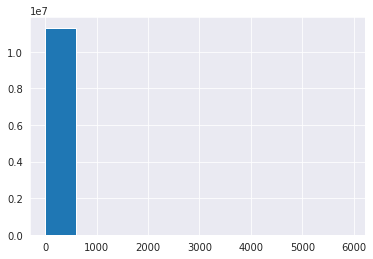

In [31]:
df['time_dropoff'] = pd.to_datetime(df.tpep_dropoff_datetime.apply(lambda x: x[:-6])) 
df['time_pickup'] = pd.to_datetime(df.tpep_pickup_datetime.apply(lambda x: x[:-6]))
df['pu_month'] = df['time_pickup'].apply(lambda x: x.month)
df['do_month'] = df['time_dropoff'].apply(lambda x: x.month)
df.drop(df[df.pu_month != df.do_month].index,inplace =True)
df.drop(df[df.time_dropoff < df.time_pickup].index,inplace=True)  

df[df.trip_distance < df.trip_distance.mean()+4*df.trip_distance.std()][df.trip_distance >0].trip_distance.hist()

In [37]:
df.trip_distance.describe()

count    1.120291e+07
mean     5.086411e+00
std      4.155808e+03
min     -3.390584e+06
25%      1.000000e+00
50%      1.660000e+00
75%      3.050000e+00
max      1.165853e+07
Name: trip_distance, dtype: float64

In [0]:
(Ymin,Ymax) = (regions.south.min(),regions.north.max())
(Xmin,Xmax) = (regions.west.min(), regions.east.max())
df.drop(df[df.dropoff_latitude <= Ymin].index,inplace =True )
df.drop(df[df.dropoff_latitude >= Ymax].index,inplace =True )
df.drop(df[df.dropoff_longitude <= Xmin].index,inplace =True )
df.drop(df[df.dropoff_longitude >= Xmax].index,inplace =True )

In [13]:
df[df.trip_distance < 40][df.trip_distance >0].count()

VendorID                 1217
tpep_pickup_datetime     1217
tpep_dropoff_datetime    1217
passenger_count          1217
trip_distance            1217
pickup_longitude         1217
pickup_latitude          1217
RatecodeID               1217
store_and_fwd_flag       1217
dropoff_longitude        1217
dropoff_latitude         1217
payment_type             1217
fare_amount              1217
extra                    1217
mta_tax                  1217
tip_amount               1217
tolls_amount             1217
improvement_surcharge    1217
total_amount             1217
dtype: int64